In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Activation
from keras.layers import TimeDistributed, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from keras import backend as K

raw = open('data_training_alo', 'r').readlines()

all_x = []
point = []
for line in raw:
    stripped_line = line.strip().replace(' ','')
    stripped_line = stripped_line.split('\t')
    if len(stripped_line) == 2:
        point.append(stripped_line)
    if line == '\n':
        all_x.append(point)
        point = []
all_x = all_x[:-1]

Using TensorFlow backend.


In [2]:
print(all_x)

[[['dok', 'O'], ['penumpukan', 'B-DISEASE'], ['cairan', 'I-DISEASE'], ['di', 'B-BBODY'], ['otak', 'I-BBODY'], ['di', 'O'], ['sebabkan', 'O'], ['karena', 'O'], ['apa', 'O']], [['malam', 'O'], ['dok', 'O'], ['saya', 'O'], ['berumur', 'O'], ['17', 'B-CHILD'], ['tahun', 'I-CHILD'], ['2', 'O'], ['minggu', 'O'], ['yang', 'O'], ['lalau', 'O'], ['saya', 'O'], ['terkena', 'O'], ['gejala', 'O'], ['pada', 'O'], ['usus', 'B-DISEASE'], ['buntu', 'I-DISEASE'], ['hanya', 'O'], ['infeksi', 'B-DISEASE'], ['tetapi', 'O'], ['dokter', 'O'], ['tidak', 'O'], ['menyarankan', 'O'], ['saya', 'O'], ['untuk', 'O'], ['operasi', 'O'], ['saya', 'O'], ['di', 'B-TREATMENT'], ['impus', 'I-TREATMENT'], ['2', 'O'], ['hari', 'O'], ['dan', 'O'], ['telah', 'O'], ['minum', 'O'], ['obat', 'O'], ['10', 'O'], ['hari', 'O'], ['saya', 'O'], ['ingin', 'O'], ['bertanya', 'O'], ['apa', 'O'], ['langkah', 'O'], ['selanjutnya', 'O'], ['yg', 'O'], ['harus', 'O'], ['saya', 'O'], ['lakukan', 'O'], ['agar', 'O'], ['dapat', 'O'], ['sembuh'

In [3]:
lengths = [len(x) for x in all_x]
print ('Input sequence length range: ', max(lengths), min(lengths))

short_x = [x for x in all_x if len(x)]

X = [[c[0] for c in x] for x in short_x]
y = [[c[1] for c in y] for y in short_x]

all_text = [c for x in X for c in x]

Input sequence length range:  135 1


In [4]:
print(X[1])

['malam', 'dok', 'saya', 'berumur', '17', 'tahun', '2', 'minggu', 'yang', 'lalau', 'saya', 'terkena', 'gejala', 'pada', 'usus', 'buntu', 'hanya', 'infeksi', 'tetapi', 'dokter', 'tidak', 'menyarankan', 'saya', 'untuk', 'operasi', 'saya', 'di', 'impus', '2', 'hari', 'dan', 'telah', 'minum', 'obat', '10', 'hari', 'saya', 'ingin', 'bertanya', 'apa', 'langkah', 'selanjutnya', 'yg', 'harus', 'saya', 'lakukan', 'agar', 'dapat', 'sembuh']


### Gunakan Label Encoder (Tokenizer tidak bisa karena tanda baca tidak masuk)

In [6]:
import json
import keras

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder

# X_train
words = list(set(all_text)) # di sort by group
word2ind = {word: index for index, word in enumerate(words)}
# ind2word = {index: word for index, word in enumerate(words)}
with open('./model-ner-bidirectional/dictionary-x.json','w') as dict_x:
    json.dump(word2ind, dict_x)

# y_train, coba diganti dengan label encoder supaya gampang di predict pake argmax
labels = list(set([c for x in y for c in x]))
label2ind = {label: (index + 1) for index, label in enumerate(labels)}
label2ind['EMPTY'] = 0
ind2label = {(index + 1): label for index, label in enumerate(labels)}
ind2label['0'] = 'EMPTY'

with open('./model-ner-bidirectional/dictionary-y-label.json','w') as dict_y_label:
    json.dump(label2ind, dict_y_label)

with open('./model-ner-bidirectional/dictionary-y-index.json','w') as dict_y_index:
    json.dump(ind2label, dict_y_index)
# print ('Vocabulary size:', len(word2ind), len(label_encoder.classes_))

maxlen_x = max(lengths)
max_y = len(labels) + 1
print ('Maximum sequence length:', maxlen_x)
# print(label_encoder.classes_)
# print(word2ind)

def encode(x, n):
    result = np.zeros(n)
    result[x] = 1
    return result

# sampai tau indexnya berapa
X_enc = [[word2ind[c] for c in x] for x in X]
X_train = pad_sequences(X_enc, maxlen=maxlen_x)
print(X_train[0])
print(X_train[0].shape)

y_enc = [[0] * (maxlen_x - len(y_)) + [label2ind[c] for c in y_] for y_ in y]
with open('./model-ner-bidirectional/dictionary-y-index.json','r') as a:
    tes = json.load(a)
print(tes['11'])
y_train = [[encode(angka,max_y) for angka in angka_sequence] for angka_sequence in y_enc]
y_train = np.array(y_train)
print(y_train[0])
print(y_train[0].shape)


Maximum sequence length: 135
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  9522  4716  9898 11470  8313 11470
  5674  3940  1046]
(135,)
O
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0

In [6]:
print(len(word2ind))

11708


In [7]:
print(X_train)

[[    0     0     0 ... 10256  8544  7832]
 [    0     0     0 ...  7026 10375 10636]
 [    0     0     0 ...  4798 11236  3174]
 ...
 [    0     0     0 ...  9981  5779  9484]
 [    0     0     0 ...  2559  1825  9478]
 [    0     0     0 ...  3274  9502  3297]]


In [28]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout, Bidirectional
from keras.models import load_model


def train():
    max_features = len(word2ind)
    embedding_size = 128
    hidden_size = 32
    lstm_size = 100
    out_size = max_y

    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen_x, mask_zero=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=lstm_size, return_sequences=True)))
    model.add(Dense(out_size))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    checkpointer = ModelCheckpoint('./model-ner-bidirectional/model.hdf5',save_best_only=True, verbose=1)
    
    model.summary()
    batch_size = 32
    model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_split = 0.2, callbacks = [checkpointer])

    # save model json
    model_json = model.to_json()
    with open('./model-ner-bidirectional/sub-model.json', 'w') as json_file: # tidak bisa pakai json.dump karena isinya banyak \ \
        json_file.write(model_json)
        

train()

# score = model.evaluate(X_test, y_test, batch_size=batch_size)
# print('Raw test score:', score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 135, 128)          1498624   
_________________________________________________________________
dropout_11 (Dropout)         (None, 135, 128)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 135, 200)          183200    
_________________________________________________________________
dense_11 (Dense)             (None, 135, 42)           8442      
_________________________________________________________________
activation_11 (Activation)   (None, 135, 42)           0         
Total params: 1,690,266
Trainable params: 1,690,266
Non-trainable params: 0
_________________________________________________________________
Train on 3932 samples, validate on 983 samples
Epoch 1/15
3932/3932 [==============================] - 90s 23ms/step - loss: 1.5729 

KeyboardInterrupt: 

In [32]:
from keras.models import load_model

def continue_last_training():
    new_model = load_model('./model-ner-bidirectional/model-tes.hdf5')
    
    checkpoint = ModelCheckpoint('./model-ner-bidirectional/model-tes.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_ = [checkpoint]
    new_model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split = 0.2, callbacks=callbacks_)

continue_last_training()

Train on 3932 samples, validate on 983 samples
Epoch 1/2
3932/3932 [==============================] - 98s 25ms/step - loss: 0.4725 - acc: 0.8666 - val_loss: 0.6588 - val_acc: 0.8313

Epoch 00001: loss improved from inf to 0.47249, saving model to ./model-ner-bidirectional/model-tes.hdf5
Epoch 2/2
3932/3932 [==============================] - 101s 26ms/step - loss: 0.3884 - acc: 0.8842 - val_loss: 0.6332 - val_acc: 0.8422

Epoch 00002: loss improved from 0.47249 to 0.38843, saving model to ./model-ner-bidirectional/model-tes.hdf5


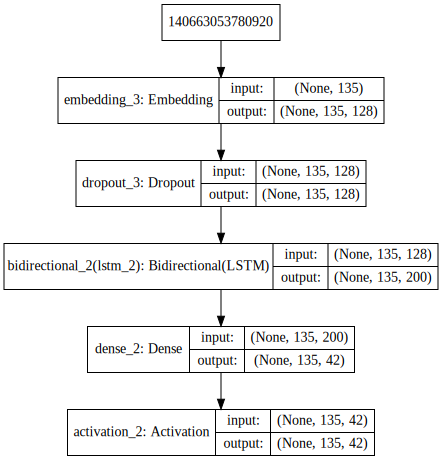

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [29]:
import keras.preprocessing.text as kpt
import json
import numpy as np
from keras.models import model_from_json,load_model

def load(string):
    max_input = 135
    # load dictionary
    with open('./model-ner-bidirectional/dictionary-x.json','r') as dict_x:
        dictionary_x = json.load(dict_x)
    
    # input
    words = [word for word in kpt.text_to_word_sequence(string) if word in dictionary_x]
    ind_dictionary = [dictionary_x[word] for word in words]
    input_ = [0]*(max_input-len(ind_dictionary))
    input_ += ind_dictionary
#     print(len(ind_dictionary)
    input_ = np.array(input_)
    print(input_)
    
    # model
    file_model = open('./model-ner-bidirectional/sub-model.json','r')
    load_model = file_model.read()
    file_model.close()
    
    # class    
    with open('./model-ner-bidirectional/dictionary-y-index.json','r') as dict_y:
        dictionary_y = json.load(dict_y)
    
#     print(dictionary_y)
    
    model = model_from_json(load_model)
    model.load_weights('./model-ner-bidirectional/model.hdf5')
    
    pred = model.predict([[input_]])
    result = []
    for i in pred:
        for k, j in zip(words,i[-len(ind_dictionary):]):
            result.append((k,dictionary_y[str(np.argmax(j))],np.max(j)))
    
    return result
    

# print(X_train[0])
string = "dok penumpukan cairan di otak di sebabkan karena apa"
string2 = "malam dok saya berumur 17 tahun 2 minggu yang lalau saya terkena gejala pada usus buntu hanya infeksi tetapi dokter tidak menyarankan saya untuk operasi saya di impus 2 hari dan telah minum obat 10 hari saya ingin bertanya apa langkah selanjutnya yg harus saya lakukan agar dapat sembuh"
string3 = "dok area kaki anak saya pertama bentol kayak digigit nyamuk lama2 jadi bentol besar gatal dan bernanah dok itu kenapa disebabkan apa yah dok"
string4 = "bekas jerawat dok ngilangin bekas jerawat pake apa yah? bekas jerawat saya di seblah pipi kanan gak ilang2.\ trus mau tanya jg kalau pelembab di pake setiap hari buat kulit yg ada bekas jerawat aman gk? wlpn itu gak keluar rumah"
string5 = "Tiroid Dok, tiroid bisa menyebabkan jantung berdebar? Apa yg harus saya lakukan jika kambuh?"
predict = load(string5)
print(predict)



[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0  6326  9522  6326  9896 10237  9673  1698  1046 10195  7075  1128
  9871  1178 11476]
[('tiroid', 'I-TREATMENT', 0.17409115), ('dok', 'O', 0.9976163), ('tiroid', 'B-DISEASE', 0.44248986), ('bisa', 'O', 0.95027965), ('menyebabkan', 'O', 0.99915683), ('jantung', 'B